# Task 1: Apply at least one model from another group to the dataset to classify the industry and compare the performances

In [1]:
# Importing Modules
import numpy as np
import pandas as pd
import regex as re
import string
import unicodedata
import nltk
import spacy
import random
nltk.download('wordnet')
!python -m spacy download en_core_web_sm >> /dev/null
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2021-11-03 21:08:06.326435: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-03 21:08:06.326474: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
# Reading in data
raw_data = pd.read_csv('employer_raw_data_group_2.csv')
sentences = raw_data['description'].values

In [3]:
# Setting up Stemmer and Lemmatizer
stemmer = nltk.stem.SnowballStemmer("english")
stop_words = []
with open("stopwords.txt", "r") as f_in:
        stop_words = [i.strip().lower() for i in f_in.readlines()]
lemmatizer = nltk.stem.WordNetLemmatizer()

In [4]:
# Creating Preprocessing function
def get_preprocessing_function(
    use_lower: bool = True,
    use_alpha: bool = True,
    use_stemming: bool = False,
    use_nodates: bool = False,
    use_nourl: bool = True,
    use_stopwords: bool=False,
    use_lemmatizer: bool=False,
    use_nocity: bool=False
):
    
    def alpha(text: str):
        return re.sub("[^a-z]+", " ", text) if use_alpha else text

    def lower(text: str):
        return text.lower() if use_lower else text
        
    def stemming(text: str):
        if use_stemming:
            text = ' '.join(stemmer.stem(x) for x in text.split())
        return text
    
    def dates(text: str):
        dates = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 
    'sept', 'oct', 'nov', 'dec'] #added abbreviations to the months list
        return " ".join([word for word in text.split(" ") if word not in dates]) if use_nodates else text

    def url(text: str):
        url_pattern = re.compile('\\S*\\.com\\b|https?://\S+|www\.\S+')
        return url_pattern.sub('', text) if use_nourl else text
    
    def remove_stopwords(text):
        return " ".join([word for word in text.split(" ") if word not in stop_words]) if use_stopwords else text
    
    def lemmatize(text: str):
        if use_lemmatizer:
            text=' '.join(lemmatizer.lemmatize(x) for x in text.split())
        return text
    
    def cityremover(text: str):
        city_state_pattern = re.compile("(?<![A-Za-z])[A-Z][a-z]+, [A-Z]{2}(?![A-Za-z])") # Matches strings like "Nashville, TN"
        return city_state_pattern.sub('city', text) if use_nocity else text

    def preprocess(text: str):
        #Create list of steps
        steps = [lower,url, alpha, dates, cityremover, remove_stopwords, lemmatize, stemming]
        for step in steps:
            text = step(text)
        return text
    
    return preprocess

In [5]:
# Instantiating preprocessing function
preprocess = get_preprocessing_function(
    use_lower= True,
    use_alpha= True,
    use_stemming= False,
    use_nodates= True,
    use_nourl= True,
    use_stopwords= True,
    use_lemmatizer= True,
    use_nocity=True
)

In [6]:
# Preprocessing data
preprocessed_data=raw_data
preprocessed_data['description'] = preprocessed_data['description'].apply(preprocess)

In [7]:
print(preprocessed_data['description'].loc[100])

rehababilities designed mind therapist owned speak language value high clinical standard ethic pride qualified experienced scheduling team therapy personnel social worker dedicated providing excellent patient care physical therapist assistant inpatient outpatient former employee corona ca rehababilities pro white male racist company accepting assignment assignment often taken away given white male replacement assignment lieu withdrawn assignment additional compensation work well rehababilities people know best inside scoop job salary top office location ceo insight compare pay popular role read team work life balance uncover rehababilities best company review rehababilities experiencing staffing agency would longer using type service longer initial hr assistance reached screened nice recruiter mark quite pushy disrespectful know staffing agency commission like car sale people matched hired rehababilities new mexico foreign profit corporation filed company filing status listed revoked f

In [8]:
# Setting up vectorizer
# We're using CountVectorizer because, from what I've read, it works better with LDA than tf_idf would
count_vectorizer = CountVectorizer(
    preprocessor=preprocess,
    ngram_range=(1,1),
    tokenizer=lambda s: s.split(),
    min_df=0.15, # Maybe 2 to 4 would be better. 0.15 is too big
    max_df=0.45  
)

In [9]:
# Fitting vectorizer and transforming sentences
count_vec = count_vectorizer.fit_transform(sentences)

In [10]:
vec = count_vectorizer.fit(sentences)
vectors = count_vectorizer.transform(sentences)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [11]:
print(count_vec.todense())
print(count_vec.todense().shape)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(20000, 273)


In [12]:
sorted(count_vectorizer.vocabulary_.items(),key=lambda x: x[1])

[('access', 0),
 ('account', 1),
 ('across', 2),
 ('active', 3),
 ('activity', 4),
 ('address', 5),
 ('america', 6),
 ('american', 7),
 ('application', 8),
 ('apply', 9),
 ('around', 10),
 ('art', 11),
 ('available', 12),
 ('b', 13),
 ('back', 14),
 ('balance', 15),
 ('benefit', 16),
 ('best', 17),
 ('better', 18),
 ('board', 19),
 ('brand', 20),
 ('building', 21),
 ('c', 22),
 ('ca', 23),
 ('california', 24),
 ('call', 25),
 ('care', 26),
 ('career', 27),
 ('center', 28),
 ('ceo', 29),
 ('change', 30),
 ('class', 31),
 ('client', 32),
 ('college', 33),
 ('come', 34),
 ('commercial', 35),
 ('committed', 36),
 ('community', 37),
 ('complete', 38),
 ('connect', 39),
 ('connection', 40),
 ('contact', 41),
 ('corporate', 42),
 ('corporation', 43),
 ('cost', 44),
 ('country', 45),
 ('county', 46),
 ('covid', 47),
 ('create', 48),
 ('culture', 49),
 ('current', 50),
 ('currently', 51),
 ('customer', 52),
 ('data', 53),
 ('date', 54),
 ('day', 55),
 ('dedicated', 56),
 ('department', 57),
 ('

In [13]:
# Setting up LDA
lda = LatentDirichletAllocation(
    n_components=20
)

In [14]:
lda.fit(count_vec)

LatentDirichletAllocation(n_components=20)

In [15]:
company_lda_vec = lda.transform(count_vec)
print(company_lda_vec)
print(company_lda_vec.shape)

[[2.87016081e-02 2.56236671e-01 3.08641980e-04 ... 3.08641982e-04
  3.03107328e-01 3.08641984e-04]
 [1.09518164e-01 1.06207762e-01 5.68181831e-04 ... 5.68181836e-04
  5.68181825e-04 5.68181831e-04]
 [4.71698120e-04 4.71698127e-04 4.71698121e-04 ... 4.71698120e-04
  4.71698117e-04 1.67413211e-02]
 ...
 [2.04184960e-02 8.62068976e-04 8.62068976e-04 ... 8.62068972e-04
  8.62068977e-04 8.62068973e-04]
 [3.18471350e-04 3.18471349e-04 3.18471347e-04 ... 5.06348592e-02
  5.12380267e-01 3.18471344e-04]
 [5.15463928e-04 5.15463929e-04 3.00311311e-01 ... 3.52902316e-02
  5.15463926e-04 5.15463923e-04]]
(20000, 20)


In [16]:
def display_topics(model, feature_names, num_top_words,topic_names=None):
     # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, topic in enumerate(model.components_):
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nCompanies ", ix)
        else:
            print("\nCompanies: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [17]:
display_topics(lda, count_vectorizer.get_feature_names(), 6)


Companies  0
group, limited, registered, private, office, global

Companies  1
technology, solution, data, industry, system, global

Companies  2
job, salary, office, employee, people, ca

Companies  3
home, manager, real, sale, west, project

Companies  4
portland, day, best, free, oregon, place

Companies  5
department, county, public, national, united, office

Companies  6
law, firm, c, client, p, practice

Companies  7
investment, financial, partner, firm, private, client

Companies  8
school, student, education, high, program, public

Companies  9
medical, center, health, care, patient, dr

Companies  10
phone, number, contact, direction, address, website

Companies  11
health, care, family, community, home, patient

Companies  12
corporation, system, design, product, industry, project

Companies  13
e, n, l, r, c, b

Companies  14
network, marketing, medium, social, account, brand

Companies  15
product, america, american, brand, market, price

Companies  16
profile, linkedin, p

#### We have now successfully vectorized the company description. Let's do the same for the industry descriptions

In [18]:
industry_data = pd.read_csv('industry_data.csv')
industry_descriptions = industry_data['description'].values

In [19]:
industry_count_vec = count_vectorizer.transform(industry_descriptions)

In [20]:
print(industry_count_vec.todense())
print(industry_count_vec.todense().shape)

[[2 5 3 ... 2 2 0]
 [0 0 5 ... 1 0 0]
 [2 2 1 ... 2 1 1]
 ...
 [1 0 2 ... 0 2 0]
 [1 1 1 ... 2 1 0]
 [2 0 2 ... 2 1 0]]
(13, 273)


In [21]:
industry_lda_vec = lda.transform(industry_count_vec)
print(industry_lda_vec)
print(industry_lda_vec.shape)

[[1.31233598e-04 2.14479348e-01 1.31233599e-04 1.31233600e-04
  8.75069016e-02 2.27954721e-02 1.31233598e-04 4.91376038e-01
  4.05608470e-02 1.31233600e-04 7.80502298e-02 1.32068656e-02
  5.04494953e-02 1.31233597e-04 1.31233600e-04 1.31233598e-04
  1.31233598e-04 1.31233599e-04 1.31233599e-04 1.31233598e-04]
 [2.36336059e-02 2.38636119e-01 1.88679249e-04 9.25167249e-02
  1.20741749e-01 3.76146084e-02 1.88679249e-04 3.63654583e-02
  1.88679248e-04 1.92189673e-02 1.88679250e-04 1.88679250e-04
  1.38666193e-01 1.88679249e-04 3.85869435e-02 1.92813455e-01
  1.88679249e-04 1.40558084e-02 1.88679249e-04 4.56409336e-02]
 [8.31487768e-03 1.24427596e-01 1.49700602e-04 1.49700602e-04
  3.15901011e-01 1.44916982e-01 1.49700604e-04 4.31986548e-02
  1.32196459e-02 1.49700602e-04 6.06282086e-02 2.46150202e-02
  6.22232887e-02 5.20544614e-03 8.35919129e-02 1.49700602e-04
  1.49700601e-04 1.49700602e-04 4.41778268e-02 6.85316249e-02]
 [1.56250002e-04 2.25789939e-01 1.56250004e-04 1.54522600e-02
  2.0

#### Next, we need to find which industry each company most closely matches

In [22]:
# First, we'll normalize all of the rows in company_lda_vec and industry_lda_vec
# Next, we'll multiply company_lda_vec with the transpose of industry_lda_vec
# This will yield a matrix with 20000 rows and 13 columns.
# Each row corresponds to a company
# Each column is the company's "similarity score" to the corresponding industry

from sklearn.preprocessing import normalize
company_lda_vec = normalize(company_lda_vec, axis = 1)
industry_lda_vec = normalize(industry_lda_vec, axis = 1)

similarity_matrix = company_lda_vec @ industry_lda_vec.T
print(similarity_matrix)
print(similarity_matrix.shape)

[[0.1755873  0.65074731 0.20114158 ... 0.1672602  0.29539351 0.45264318]
 [0.37788264 0.29949586 0.13120179 ... 0.11342121 0.14669239 0.15453416]
 [0.11692364 0.30550277 0.72092866 ... 0.60477908 0.23756838 0.00890851]
 ...
 [0.2027018  0.16273876 0.5251802  ... 0.00283506 0.41189053 0.00445648]
 [0.18580231 0.10559776 0.21441768 ... 0.02472229 0.16308395 0.06315586]
 [0.0465408  0.04746313 0.06004903 ... 0.01372661 0.09729599 0.02703805]]
(20000, 13)


<AxesSubplot:ylabel='Count'>

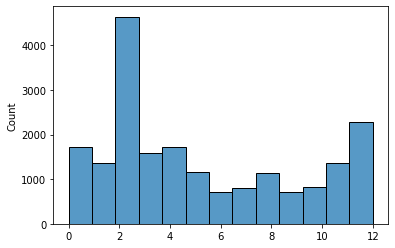

In [23]:
# Now, we can take the argmax to find which industry each company best fits
industry_classifications = np.argmax(similarity_matrix, axis = 1)

import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(industry_classifications, bins = 13)

In [24]:
prediction_data = raw_data

prediction_data['prediction_num'] = industry_classifications

num_to_industry = lambda x: industry_data['industry'].loc[x]

prediction_data['prediction'] = prediction_data['prediction_num'].apply(num_to_industry)

In [25]:
raw_data.sample(5)

,employers,description,prediction_num,prediction
17105,clark hill law firm,corporate law healthcare law clark hill full s...,11,Consumer Services
19487,new york state athletic commission,overview combat sport new state sanctioned reg...,5,Government
5940,eastern kentucky university,eastern kentucky university announced received...,2,Business Services
16784,center for advanced hindsight,behavioral design podcast habit weekly center ...,7,Non-Profit
19382,black & veatch management consulting llc,global industry consulting leader team draw va...,4,Energy and Utilities


These predictions are very bad. 

# Task 2:the word vector representation, how do you think this model performs compare to the others. Create a embeddings representation of each industry using spacy and find the closest industry using doc_1.similarity(industry_1)

In [26]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"]) #get the word embedding model

In [27]:
# Re-reading the data, just to refresh from the previous session
raw_data = pd.read_csv('employer_raw_data_group_2.csv')
sentences = raw_data['description'].values
industry_data = pd.read_csv('industry_data.csv')
industry_descriptions = industry_data['description'].values

In [28]:
# We were using CountVectorizer above. We will now switch to TFIDF 
MIN_DF = 2
MAX_DF = 0.4
vec = TfidfVectorizer(
    preprocessor= preprocess,
    tokenizer=lambda s: s.split(),
    min_df=MIN_DF,
    max_df=MAX_DF,
    use_idf=True,
    smooth_idf=True
)
vec = vec.fit(sentences)
vectors = vec.transform(sentences)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [29]:
top_n = 50 #maybe use 25 instead or lower

words = np.array(vec.get_feature_names())
res = []
for i in range(vectors.shape[0]):
    # Will get the words that are in the TFIDF which have the higher score
    # We use -vectors because the order is ascending
    s = np.argsort(np.asarray(-vectors[i, :].todense()).flatten())
    res.append(" ".join(words[s[:top_n]]))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
data_documents = [nlp(description) for description in res)]

SyntaxError: invalid syntax (<ipython-input-30-121359bec5cb>, line 1)

In [ ]:
vector1

array([ 7.02645719e-01, -1.68836266e-01,  2.61854976e-01, -3.84303220e-02,
        4.65661474e-02, -1.67919248e-01, -2.95927972e-01,  3.22961032e-01,
       -3.64984691e-01,  7.85891414e-02,  4.46066141e-01, -2.69639939e-01,
        1.20276317e-01, -1.94166720e-01, -4.90692586e-01,  4.66974169e-01,
       -1.50962211e-02,  2.40982577e-01, -5.04387498e-01, -1.00908853e-01,
       -1.87064856e-01,  4.67575230e-02,  8.88164788e-02, -1.92914754e-01,
        1.30501360e-01, -3.76936078e-01,  4.09645855e-01, -3.62187684e-01,
        2.27998853e-01, -2.35117480e-01, -1.34770587e-01, -1.01859160e-02,
       -2.93851420e-02, -2.90815055e-01,  7.87873864e-02, -3.43523860e-01,
        4.29382926e-04,  1.38496071e-01,  2.48840854e-01,  6.27460957e-01,
        1.21669389e-01,  1.49951175e-01, -3.93357426e-01,  1.01098776e-01,
        3.54889184e-02, -1.45836309e-01, -1.79082633e-03,  2.14475915e-01,
       -1.39374122e-01, -1.90969244e-01,  3.43208194e-01, -1.65164754e-01,
       -1.58521697e-01,  

In [ ]:
industry_vectors = vec.transform(industry_descriptions)
industry_vec = vec.fit(industry_descriptions)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
top_n = 50

words = np.array(industry_vec.get_feature_names())
industry_res = []
for i in range(industry_vectors.shape[0]):
    # Will get the words that are in the TFIDF which have the higher score
    # We use -vectors because the order is ascending
    s = np.argsort(np.asarray(-industry_vectors[i, :].todense()).flatten())
    industry_res.append(" ".join(words[s[:top_n]]))
    #error here

IndexError: index 27285 is out of bounds for axis 0 with size 1278

In [ ]:
industry_documents = [nlp(description) for description in industry_res)]

In [ ]:
# Comparing each sentence to each industry description, creating a 20,000 X 13 matrix

comparison_matrix = np.zeros((20000,13))

for i, data_document in enumerate(data_documents):
    for j, industry_document in enumerate(industry_documents):
        comparison_matrix[i,j] = 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=262b3d28-05ef-49db-b57a-efab2f090880' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>